# Walking

In [1]:
import sys
sys.path.append("../../../")

import torch as th

from mowl.datasets.ppi_yeast import PPIYeastSlimDataset

from mowl.embeddings.graph_based.dl2vec.model import DL2Vec
from gensim.models import Word2Vec
import pickle as pkl
import numpy as np
#from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

from mowl.graph.util import parser_factory
from mowl.walking.util import walking_factory
from mowl.walking.node2vec.model import Node2Vec as N2V
from mowl.walking.node2vec.modelscala import Node2Vec as N2VS

from mowl.walking.deepwalk.model import DeepWalk as DW
import gensim
import logging
import time

logging.basicConfig(set_level = logging.INFO)


## Example with DL2Vec

In [2]:

logging.info("Creating dataset...")
start = time.time()
dataset = PPIYeastSlimDataset()
end = time.time()
logging.info("Dataset created in %f seconds", end-start)

logging.info("Projecting graph...")
start = time.time()
parser = parser_factory(
    "dl2vec", # taxonomy, taxonomy_rels, owl2vec_star
    dataset.ontology, 
    bidirectional_taxonomy=True)

edges = parser.parse()
end = time.time()
logging.info("Graph projected in %f seconds", end - start)



INFO:root:Creating dataset...
INFO:root:Dataset created in 0.370995 seconds
INFO:root:Projecting graph...


INFO: Number of ontology classes: 11020


INFO:root:Graph projected in 13.067804 seconds


In [3]:
logging.info("Walking..")
start = time.time()

walker = DW(
        edges, 
        1600, #num_walks 
        100, #walk_length 
        0.1, #q
        16, #num_workers,
        outfile = "data/walks_deepwalk1600"
    )

walker.walk()
end = time.time()
logging.info("Walks generated in %f seconds", end - start)



INFO:root:Walking..


Starting pool...+ started processing 12
+ started processing 13
+ started processing 11
+ started processing 9
+ started processing 5
+ started processing 8
+ started processing 6
+ started processing 4
+ started processing 1
+ started processing 7
+ started processing 14
+ started processing 10
+ started processing 2
+ started processing 0
+ started processing 15
+ started processing 3


INFO:root:Walks generated in 20.698777 seconds


- finished processing 13 after 19609
- finished processing 7 after 19612
- finished processing 11 after 19616
- finished processing 9 after 19624
- finished processing 14 after 19631
- finished processing 8 after 19652
- finished processing 3 after 19655
- finished processing 0 after 19662
- finished processing 12 after 19665
- finished processing 4 after 19666
- finished processing 1 after 19666
- finished processing 5 after 19668
- finished processing 2 after 19669
- finished processing 6 after 19674
- finished processing 10 after 19696
- finished processing 15 after 19700
* processing is over, shutting down the executor


In [4]:
#sentences = gensim.models.word2vec.LineSentence(walks_outfile)
logging.info("Learning embeddings..")
start = time.time()

model = gensim.models.Word2Vec(
    sentences, 
    sg=1, 
    min_count=1, 
    size=100, 
    window = 10, 
    iter = 10, 
    workers = 8)

model.save("data/walks_deepwalk")
end = time.time()
logging.info("Embeddings learned in %f seconds", end - start)



INFO:root:Learning embeddings..


NameError: name 'sentences' is not defined

In [10]:
from mowl.graph.edge import Edge

entities, _ = Edge.getEntitiesAndRelations(edges)

word2VecModel = Word2Vec.load("data/walks_deepwalk")
vectors = word2VecModel.wv

deepwalk_embeddings = {}
for node in entities:
    if node.startswith("4932"):
        deepwalk_embeddings[node] = vectors[node]
        
with open("data/deepwalk_emb", "wb") as file:
    pkl.dump(deepwalk_embeddings, file)

INFO:gensim.utils:loading Word2Vec object from data/walks_deepwalk
INFO:gensim.utils:loading wv recursively from data/walks_deepwalk.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from data/walks_deepwalk.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from data/walks_deepwalk.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded data/walks_deepwalk


In [11]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [12]:
ec_dict = {}
for prot in ec_numbers:
    if prot in deepwalk_embeddings:
        ec_dict[prot] = deepwalk_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

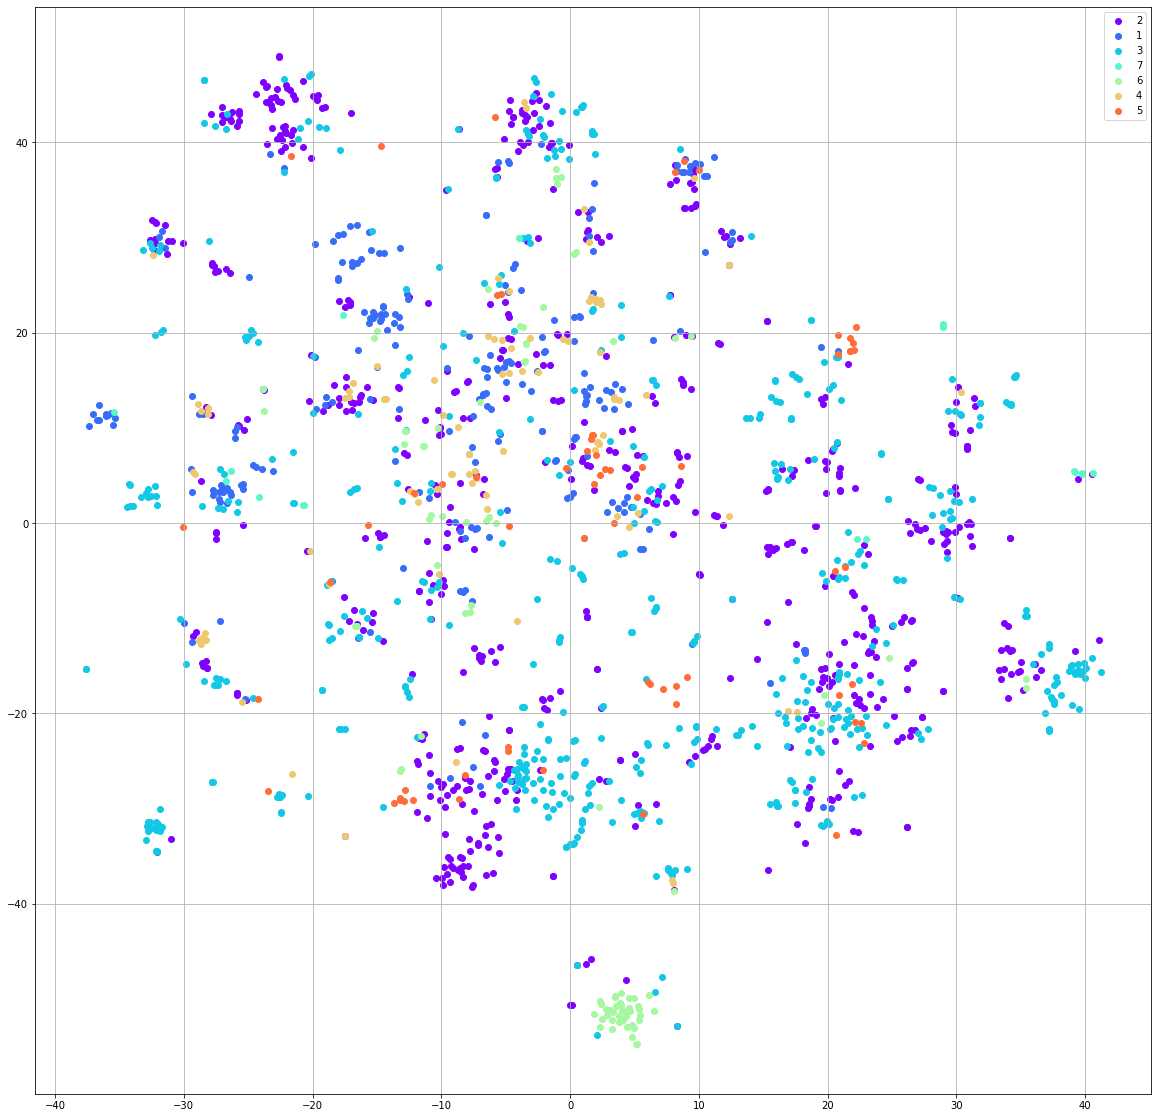

In [13]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.show()

In [10]:
type(walker.model.walks)

numpy.ndarray

## Example with Node2Vec

In [4]:
logging.info("Walking..")
start = time.time()

walker = N2VS(
        edges, 
        1600, #num_walks 
        100, #walk_length 
        10, #p
        0.1, #q
        num_workers = 16, #num_workers,
        outfile = 'data/walks_node2vec100seq'
    )
    
walker.walk()
end = time.time()
logging.info("Walks generated in %f seconds", end - start)


#sentences = walker.walks


INFO:root:Walking..


Starting pool...+ started preprocessing probabilities...
Thread 0, nodes to process 368
Thread 7, nodes to process 390
Thread 1, nodes to process 379
Thread 2, nodes to process 393
Thread 10, nodes to process 362
Thread 4, nodes to process 375
Thread 5, nodes to process 382
Thread 9, nodes to process 390
Thread 3, nodes to process 387
Thread 12, nodes to process 411
Thread 13, nodes to process 393
Thread 8, nodes to process 400
Thread 6, nodes to process 391
Thread 11, nodes to process 402
Thread 15, nodes to process 389
Thread 14, nodes to process 386
* processing nodes is over
Thread 15, edges to process 15573
Thread 0, edges to process 15574
Thread 5, edges to process 15574
Thread 12, edges to process 15573
Thread 11, edges to process 15573
Thread 8, edges to process 15574
Thread 14, edges to process 15573
Thread 7, edges to process 15574
Thread 1, edges to process 15574
Thread 2, edges to process 15574
Thread 6, edges to process 15574
Thread 3, edges to process 15574
Thread 9, edge

INFO:root:Walks generated in 50.673835 seconds


- finished processing 8 after 44991
- finished processing 1 after 45006
- finished processing 9 after 45008
- finished processing 7 after 45011
- finished processing 13 after 45022
- finished processing 4 after 45024
- finished processing 14 after 45048
- finished processing 5 after 45052
- finished processing 11 after 45059
- finished processing 2 after 45069
- finished processing 15 after 45080
- finished processing 0 after 45082
- finished processing 6 after 45083
- finished processing 3 after 45105
- finished processing 10 after 45102
- finished processing 12 after 45142
* processing is over, shutting down the executor


In [5]:
logging.info("Learning embeddings..")
start = time.time()

model = gensim.models.Word2Vec(
    sentences, 
    sg=1, 
    min_count=1, 
    size=100, 
    window = 10, 
    iter = 1, 
    workers = 8)

model.save("data/walks_node2vec")
end = time.time()
logging.info("Embeddings learned in %f seconds", end - start)


INFO:root:Learning embeddings..
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 1000000 words, keeping 10683 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 2000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 3000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 4000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 5000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 6000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 7000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #8

INFO:gensim.models.word2vec:PROGRESS: at sentence #740000, processed 74000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #750000, processed 75000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #760000, processed 76000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #770000, processed 77000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #780000, processed 78000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #790000, processed 79000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #800000, processed 80000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #810000, processed 81000000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #820000, processed 82000000 words, keeping 11020 word types
INFO:gensi

INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 74.91% examples, 425037 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 77.50% examples, 425028 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 80.08% examples, 425018 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 82.65% examples, 424920 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 85.28% examples, 424995 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 87.87% examples, 425030 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 90.50% examples, 425394 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 93.10% examples, 425364 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 95.73% examples, 425549 words/s, in_qsize

In [6]:
from mowl.graph.edge import Edge
entities, _ = Edge.getEntitiesAndRelations(edges)

word2VecModel = Word2Vec.load("data/walks_node2vec")
vectors = word2VecModel.wv

node2vec_embeddings = {}
for node in entities:
    if node.startswith("4932"):
        node2vec_embeddings[node] = vectors[node]
        
with open("data/node2vec_emb", "wb") as file:
    pkl.dump(node2vec_embeddings, file)

INFO:gensim.utils:loading Word2Vec object from data/walks_node2vec
INFO:gensim.utils:loading wv recursively from data/walks_node2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from data/walks_node2vec.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from data/walks_node2vec.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded data/walks_node2vec


In [7]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [8]:
ec_dict = {}
for prot in ec_numbers:
    if prot in node2vec_embeddings:
        ec_dict[prot] = node2vec_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

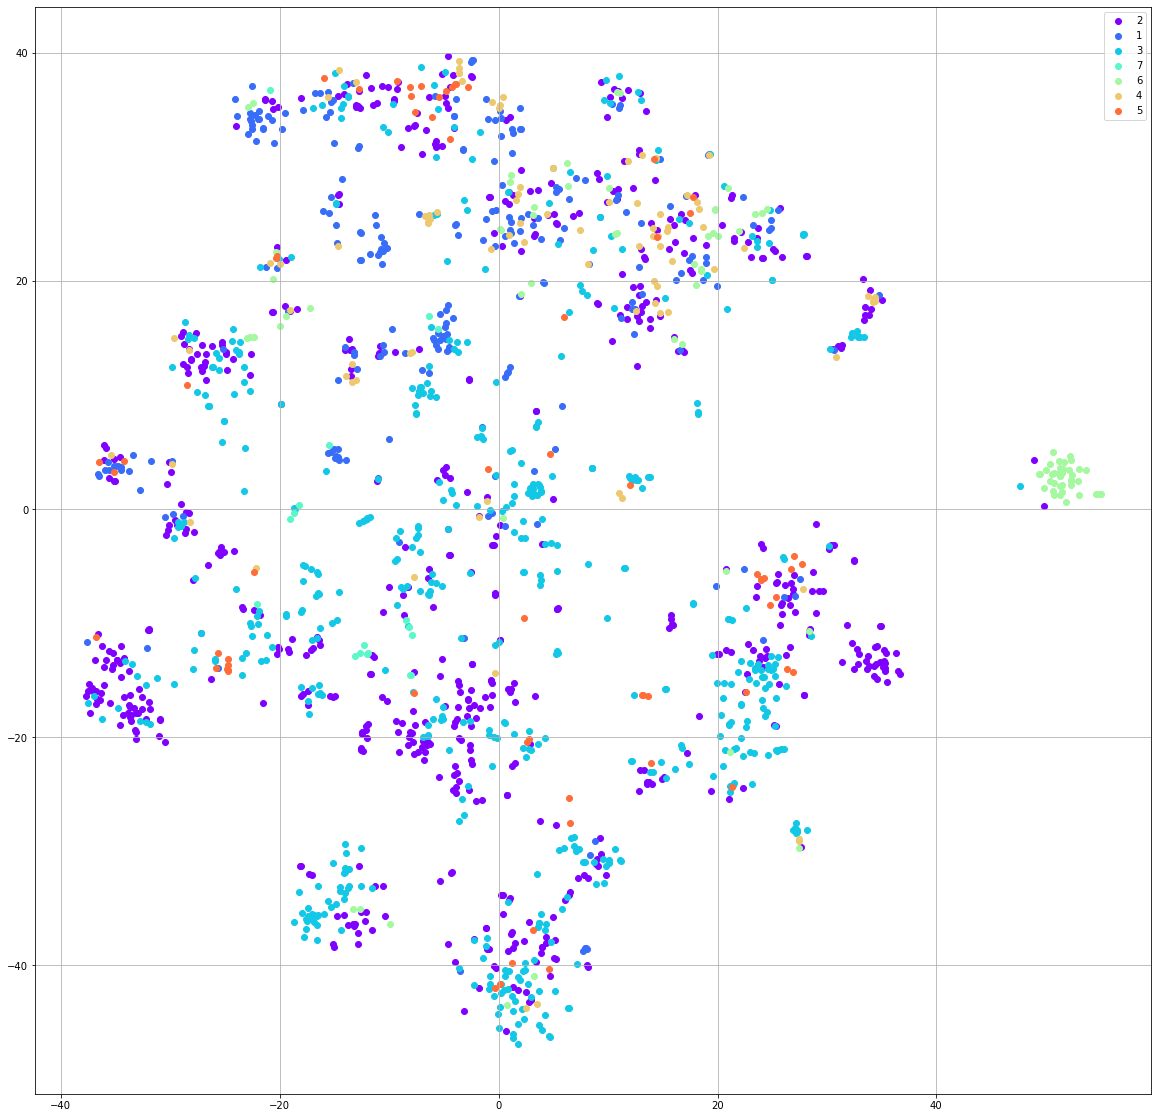

In [9]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.show()